In [ ]:
print(f'Start Spark name:{spark._sc.appName}, version:{spark.version}')

import os
print(f"remote USER={os.getenv('USER',None)}")

In [1]:
%%local
import os
print(f"local USER={os.getenv('USER',None)}")

local USER=leclercq


In [2]:
%%local
import os
username=os.getenv('USER', 'anonymous')
hadoop_fs=os.getenv('HADOOP_DEFAULT_FS', 'hdfs://iccluster065.iccluster.epfl.ch:8020')
print(f"local username={username}\nhadoop_fs={hadoop_fs}")

local username=leclercq
hadoop_fs=hdfs://iccluster067.iccluster.epfl.ch:8020


In [3]:
 # (prevent deprecated np.bool error since numpy 1.24, until a new version of pandas/Spark fixes this)
import numpy as np
np.bool = np.bool_

username=spark.conf.get('spark.executorEnv.USERNAME', 'anonymous')
hadoop_fs=spark.conf.get('spark.executorEnv.HADOOP_DEFAULT_FS','hdfs://iccluster065.iccluster.epfl.ch:8020')
print(f"remote username={username}\nhadoop_fs={hadoop_fs}")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
5650,application_1713270977862_6345,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

remote username=leclercq
hadoop_fs=hdfs://iccluster067.iccluster.epfl.ch:8020

In [4]:
spark.sql(f"ADD JARS {hadoop_fs}/data/jars/esri-geometry-api-2.2.4.jar")
spark.sql(f"ADD JARS {hadoop_fs}/data/jars/spatial-sdk-hive-2.2.0.jar")
spark.sql(f"ADD JARS {hadoop_fs}/data/jars/spatial-sdk-json-2.2.0.jar")

spark.sql("CREATE OR REPLACE TEMPORARY FUNCTION ST_Distance AS 'com.esri.hadoop.hive.ST_Distance'")
spark.sql("CREATE OR REPLACE TEMPORARY FUNCTION ST_Point AS 'com.esri.hadoop.hive.ST_Point'")
spark.sql("CREATE OR REPLACE TEMPORARY FUNCTION ST_SetSRID AS 'com.esri.hadoop.hive.ST_SetSRID'")
spark.sql("CREATE OR REPLACE TEMPORARY FUNCTION ST_Contains AS 'com.esri.hadoop.hive.ST_Contains'")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[]

# Import data

In [5]:
region_name, region_id = "lausanne", 2056

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import StringType

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Directory path
hdfs_path = f"/user/{username}/livy"

hadoop_conf = spark.sparkContext._jsc.hadoopConfiguration()
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(hadoop_conf)

# List files in the directory
path = spark._jvm.org.apache.hadoop.fs.Path(hdfs_path)
file_status = fs.listStatus(path)
files = [file.getPath().getName() for file in file_status]

# Print the list of files
for file in files:
    print(file)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

coefficients_lr
coefficients_lr.csv
orc_data_bern_feb
orc_data_bern_feb.orc
orc_data_graph_one_day_lausanne
orc_data_istdaten_lausanne
orc_data_pred_delay_jan_lausanne
orc_data_pred_delay_jan_lausanne.orc
orc_data_pred_delay_lausanne
orc_data_pred_delay_lausanne.orc
orc_data_prediction_one_day_lausanne
orc_data_train
orc_data_train.orc

In [8]:
df = spark.read.orc(f"/user/{username}/livy/orc_data_prediction_one_day_{region_name}")
print(df.count())
df.show(n=5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1365180
+----------------+-----------+--------------+----------+-------+-------+-----+----+-------+------------+-----------+------------+-----------+----------------+---------------+----------------+---------------+---------------+--------------+-------------+----------+-------------------+
|fahrt_bezeichner|linien_text|parent_station|produkt_id|  bpuic|stop_id|month|hour|day_cat|ankunftszeit|an_prognose|abfahrtszeit|ab_prognose|ankunftszeit_sec|an_prognose_sec|abfahrtszeit_sec|ab_prognose_sec|       stop_lat|      stop_lon|    stop_name|delay_bool|              delay|
+----------------+-----------+--------------+----------+-------+-------+-----+----+-------+------------+-----------+------------+-----------+----------------+---------------+----------------+---------------+---------------+--------------+-------------+----------+-------------------+
|   85:55:104:000|        R20| Parent8501181|       Zug|8501181|8501181|    1|   6| Monday|       06:05|   06:04:08|        null|       null

In [10]:
df.select("produkt_id").distinct().collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(produkt_id='Bus'), Row(produkt_id='Metro'), Row(produkt_id='Zug'), Row(produkt_id='')]

## Create weather data

In [11]:
# weather data: site, lat, lon
weather = spark.read.csv('/data/wunderground/csv/stations', header=True)
print(weather.show(n=3))

unique_stops = df.select(["bpuic", "stop_lat", "stop_lon"]).distinct()
unique_stops.createOrReplaceTempView("unique_stops")
weather.createOrReplaceTempView("weather")

# Calculate distances
distance_df = spark.sql("""
    SELECT 
        s1.bpuic,
        s1.stop_lat,
        s1.stop_lon,
        s2.site,
        s2.lat_wgs84,
        s2.lon_wgs84,
        ST_Distance(ST_Point(s1.stop_lon, s1.stop_lat), ST_Point(s2.lon_wgs84, s2.lat_wgs84)) AS distance
    FROM unique_stops s1
    CROSS JOIN weather s2
""")

distance_df.createOrReplaceTempView("distance_df")
nearest_site_df = spark.sql("""
    WITH MinDistances AS (
        SELECT
            bpuic,
            MIN(distance) AS min_distance
        FROM distance_df
        GROUP BY bpuic
    )
    SELECT
        d.bpuic,
        d.stop_lat,
        d.stop_lon,
        d.site
    FROM distance_df d
    JOIN MinDistances m ON d.bpuic = m.bpuic AND d.distance = m.min_distance
""")

df_with_sites = (df
                 .alias("df")
                 .join(nearest_site_df.alias("nsd"), F.col("df.bpuic") == F.col("nsd.bpuic"), "inner")
                 .dropDuplicates(["bpuic", "month", "day_cat", "hour"])
                )

# create weather table for each site
spark.sql(f"DROP TABLE IF EXISTS {username}.weather_for_sites")
query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {username}.weather_for_sites (
    obs_id STRING,
    obs_name STRING,
    valid_time_gmt INT,
    expire_time_gmt INT,
    temp INT,
    pressure DOUBLE,
    rh INT,
    precip_hrly DOUBLE,
    snow_hrly DOUBLE,
    wpsd DOUBLE
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.JsonSerDe'
PARTITIONED BY (site STRING, year INT, month INT)
STORED AS TEXTFILE
LOCATION '/data/wunderground/json/history'
"""
spark.sql(query)

# add data
unique_sites = weather.select(["site"]).distinct().collect()
year, month = 2024, 1

for site_row in unique_sites:
    site = site_row['site']
    spark.sql(f"""
    ALTER TABLE {username}.weather_for_sites ADD PARTITION (site='{site}', year={year}, month={month:02d}) 
    LOCATION '/data/wunderground/json/history/site={site}/year={year}/month={month:02d}'
    """)

# format data
weather_for_sites = spark.sql(f"SELECT * FROM {username}.weather_for_sites")
weather_for_sites = weather_for_sites.withColumn("valid_time_gmt", F.from_utc_timestamp(F.from_unixtime(F.col("valid_time_gmt").cast("bigint")), "GMT").alias("valid_time_gmt"))
weather_for_sites = weather_for_sites.withColumn("expire_time_gmt", F.from_utc_timestamp(F.from_unixtime(F.col("expire_time_gmt").cast("bigint")), "GMT").alias("expire_time_gmt"))
weather_for_sites = weather_for_sites.withColumn("dayofmonth", F.dayofmonth(F.from_unixtime(F.col("valid_time_gmt").cast("bigint"))))
weather_for_sites = weather_for_sites.withColumn("hour", F.hour(F.from_unixtime(F.col("valid_time_gmt").cast("bigint"))))
weather_for_sites = weather_for_sites.withColumn("minute", F.minute(F.from_unixtime(F.col("valid_time_gmt").cast("bigint"))))
weather_for_sites = weather_for_sites.filter(F.dayofweek(F.col("valid_time_gmt")) == 2) # mondays
weather_for_sites = weather_for_sites.withColumn("day_cat", F.date_format("valid_time_gmt", "EEEE"))

# hourly data
weather_df_avg_hourly = (weather_for_sites
                        .select("site", "year", "month", "dayofmonth", "day_cat", "hour", "precip_hrly", "temp", "wpsd", "snow_hrly")
                        .groupBy("site", "year", "month", "dayofmonth", "hour")
                        .agg(F.avg("precip_hrly").alias("avg_precip"),
                             F.avg("temp").alias("avg_temp"),
                             F.avg("wpsd").alias("avg_wpsd"),
                             F.avg("snow_hrly").alias("avg_snow"),
                             F.first("day_cat").alias("day_cat"))
                       ) #hour


# Rank 
hourly_window_precip = Window.partitionBy("year", "month", "dayofmonth", "hour").orderBy(F.col("avg_precip").desc())
hourly_window_temp = Window.partitionBy("year", "month", "dayofmonth", "hour").orderBy(F.col("avg_temp"))
hourly_rank = weather_df_avg_hourly.withColumn("rank_precip", F.rank().over(hourly_window_precip)).withColumn("rank_temp", F.rank().over(hourly_window_temp))

def evaluate_weather(rank_precip, rank_temp, avg_temp):
   
    if rank_precip is None:
        rank_precip = float('inf')  
    if rank_temp is None:
        rank_temp = float('inf')  
    if avg_temp is None:
        avg_temp = float('inf') 
        
    if rank_precip <= 5 or (avg_temp <= 3 and rank_temp <= 5):
        return "Bad"
    else:
        return "Good"


evaluate_weather_udf = F.udf(evaluate_weather, StringType())
evaluate_hourly_weather = hourly_rank.withColumn("evaluate_weather", evaluate_weather_udf(F.col("rank_precip"), F.col("rank_temp"), F.col("avg_temp"))).withColumnRenamed("dayofmonth", "day")


def count_rank_evaluate_weather(good_count, bad_count):
    if good_count > bad_count:
        return 'Good'
    elif bad_count > good_count:
        return 'Bad'
    else:
        return 'Good'

evaluate_weather_udf = F.udf(count_rank_evaluate_weather, StringType())
evaluate_hourly_weather = (evaluate_hourly_weather
                           .groupBy("year", "month", "day_cat", "hour", "site")
                           .agg(
                               F.sum(F.when(F.col("evaluate_weather") == 'Good', 1).otherwise(0)).alias("good_count"),
                               F.sum(F.when(F.col("evaluate_weather") == 'Bad', 1).otherwise(0)).alias("bad_count")
                           )
                          )
evaluate_hourly_weather = evaluate_hourly_weather.withColumn("weather_evaluation", evaluate_weather_udf(F.col("good_count"), F.col("bad_count")))


df_with_weather = df_with_sites.join(evaluate_hourly_weather, ["month", "day_cat", "hour", "site"])
df_with_weather = df_with_weather.select("linien_text", "produkt_id", "hour", "day_cat", "df.stop_lat", "df.stop_lon", "delay_bool", "delay", "weather_evaluation")
print(df_with_weather.show(n=10))

df_bad_weather = df_with_weather.filter(F.col("weather_evaluation") == "Bad")
df_good_weather = df_with_weather.filter(F.col("weather_evaluation") == "Good")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+----------+---------+---------+---------+
|site|   lat_dms|  lon_dms|lat_wgs84|lon_wgs84|
+----+----------+---------+---------+---------+
|LSZH|N47°27.48'|E8°32.88'|47.458000| 8.548000|
|LSMP|N46°50.55'|E6°54.82'|46.842500| 6.913667|
|LSMM|N46°44.50'| E8°6.50'|46.741667| 8.108333|
+----+----------+---------+---------+---------+
only showing top 3 rows

None
+-----------+----------+----+-------+---------------+--------------+----------+-------------------+------------------+
|linien_text|produkt_id|hour|day_cat|       stop_lat|      stop_lon|delay_bool|              delay|weather_evaluation|
+-----------+----------+----+-------+---------------+--------------+----------+-------------------+------------------+
|        IC1|       Zug|   6| Monday|46.516793104755|6.629090690624|     false|  2.033333333333333|               Bad|
|        IC1|       Zug|   7| Monday|46.516793104755|6.629090690624|     false|               0.65|               Bad|
|        IC1|       Zug|   8| Monday|46

# Delay visualization

### Visualization of delays by transport mode

In [12]:
%%spark -o df_bus
from pyspark.sql import functions as F
df_bus = df.filter(F.col("produkt_id") == "Bus")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, pl

In [13]:
%%spark -o df_train
df_train = df.filter(F.col("produkt_id") == "Zug")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, pl

In [14]:
%%spark -o df_metro
df_metro = df.filter(F.col("produkt_id") == "Metro")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/opt/conda/lib/python3.11/site-packages/sparkmagic/utils/utils.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, pl

In [15]:
%%local 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(df_bus.shape)
print(df_train.shape)
print(df_metro.shape)

(2500, 22)
(2500, 22)
(2500, 22)


In [16]:
%%local
# balance
print("bus:\n", df_bus.delay_bool.value_counts(normalize=True))
print("train:\n", df_train.delay_bool.value_counts(normalize=True))
print("metro:\n", df_metro.delay_bool.value_counts(normalize=True))

bus:
 delay_bool
False    0.968
True     0.032
Name: proportion, dtype: float64
train:
 delay_bool
False    0.986
True     0.014
Name: proportion, dtype: float64
metro:
 delay_bool
False    0.994
True     0.006
Name: proportion, dtype: float64


In [17]:
%%local
df_bus.head()

Output()

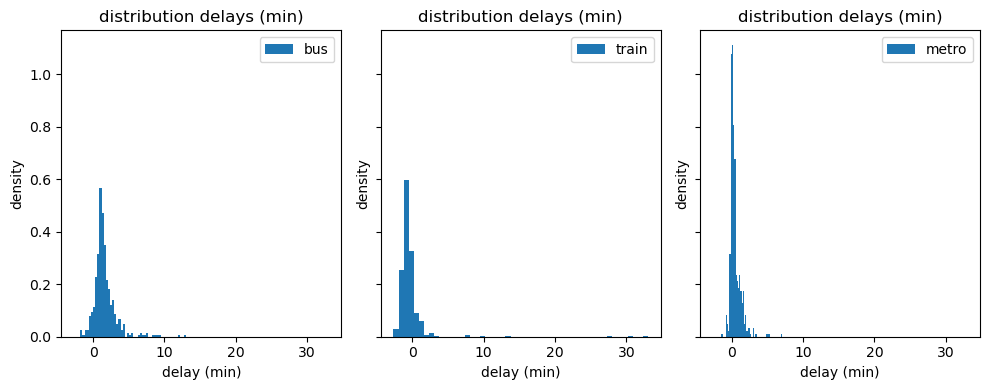

In [18]:
%%local
# delay by transport
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

ax[0].hist(df_bus.delay, label="bus", density=True, bins=50)
ax[0].set_title("distribution delays (min)")
ax[0].set_xlabel("delay (min)")
ax[0].set_ylabel("density")
ax[0].legend(loc="best")

ax[1].hist(df_train.delay, label="train", density=True, bins=50)
ax[1].set_title("distribution delays (min)")
ax[1].set_xlabel("delay (min)")
ax[1].set_ylabel("density")
ax[1].legend(loc="best")

ax[2].hist(df_metro.delay, label="metro", density=True, bins=50)
ax[2].set_title("distribution delays (min)")
ax[2].set_xlabel("delay (min)")
ax[2].set_ylabel("density")
ax[2].legend(loc="best")

plt.tight_layout()
plt.show()

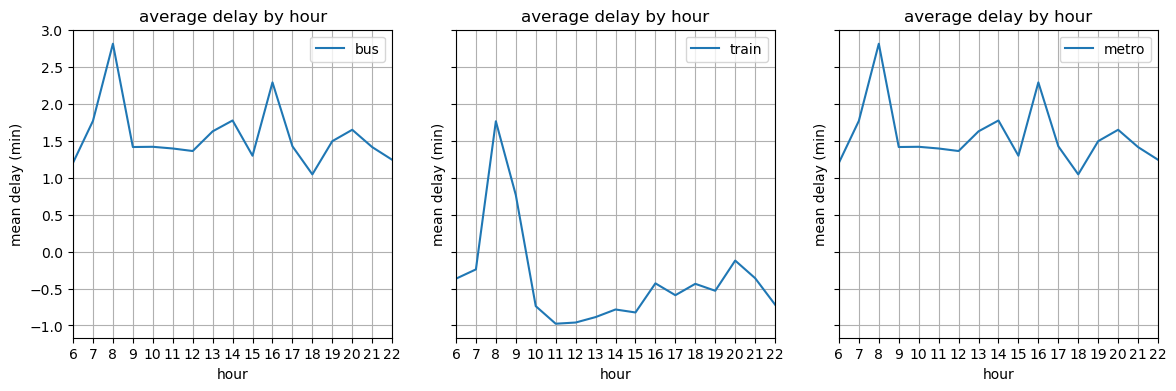

In [19]:
%%local
# delay by hour
mean_delay_bus = df_bus.groupby("hour")["delay"].agg("mean")
mean_delay_train = df_train.groupby("hour")["delay"].agg("mean")
mean_delay_metro = df_bus.groupby("hour")["delay"].agg("mean")

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

ax[0].plot(mean_delay_bus.index, mean_delay_bus.values, label="bus")
ax[0].set_xlabel("hour")
ax[0].set_ylabel("mean delay (min)")
ax[0].set_title("average delay by hour")
ax[0].legend(loc="best")
ax[0].set_xticks(mean_delay_bus.index)
ax[0].grid(True)
ax[0].set_xlim(mean_delay_bus.index.min(), mean_delay_bus.index.max())

ax[1].plot(mean_delay_train.index, mean_delay_train.values, label="train")
ax[1].set_xlabel("hour")
ax[1].set_ylabel("mean delay (min)")
ax[1].set_title("average delay by hour")
ax[1].legend(loc="best")
ax[1].set_xticks(mean_delay_train.index)
ax[1].grid(True)
ax[1].set_xlim(mean_delay_train.index.min(), mean_delay_train.index.max())

ax[2].plot(mean_delay_metro.index, mean_delay_metro.values, label="metro")
ax[2].set_xlabel("hour")
ax[2].set_ylabel("mean delay (min)")
ax[2].set_title("average delay by hour")
ax[2].legend(loc="best")
ax[2].set_xticks(mean_delay_metro.index)
ax[2].grid(True)
ax[2].set_xlim(mean_delay_metro.index.min(), mean_delay_metro.index.max())

plt.show()

__Observation__: we can clearly see that first, the mean of transport is important (delays are more import for a train), and that there are spikes in the morning and the evening across transport types, with low (even negative) delays around early morning, midday and late at night.

__Consequences__: we create a new feature named _rush_hour_ that is a boolean for whether we are looking at rush hours data (7h-11h and 17h-20h).

### Compute peak/rush hours

In [9]:
# select relevant columns for training models
data_train = df.select("linien_text", "produkt_id", "hour", "day_cat", "stop_lat", "stop_lon", "delay_bool", "delay")
data_train.show(n=5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+----+-------+---------------+--------------+----------+-------------------+
|linien_text|produkt_id|hour|day_cat|       stop_lat|      stop_lon|delay_bool|              delay|
+-----------+----------+----+-------+---------------+--------------+----------+-------------------+
|        R20|       Zug|   6| Monday|46.520798688504|6.630339348869|     false|-0.8666666666666667|
|        R20|       Zug|   6| Monday|46.520798688504|6.630339348869|     false|-0.8666666666666667|
|        R20|       Zug|   6| Monday|46.520798688504|6.630339348869|     false|-0.8666666666666667|
|        R20|       Zug|   6| Monday|46.520798688504|6.630339348869|     false|-0.8666666666666667|
|        R20|       Zug|   6| Monday|46.520798688504|6.630339348869|     false|-0.8666666666666667|
+-----------+----------+----+-------+---------------+--------------+----------+-------------------+
only showing top 5 rows

In [10]:
# systematic way to compute rush hours by transport type
stats_delay = data_train.groupBy("produkt_id").agg(
    F.mean(F.col("delay")).alias("mean_delay"),
    F.stddev(F.col("delay")).alias("std_delay")
)
print(stats_delay.show(n=5))

# condition for rush hour
data_train_stats_delay = data_train.join(stats_delay, on="produkt_id")

# get peak hours
thresholds = F.col("delay") >= 5
peak_hours = data_train_stats_delay.filter(thresholds).select("produkt_id", "hour")

# peak hours -> when number of delays >= mean number of delays (by transport type)
peak_hour_counts = peak_hours.groupBy("produkt_id", "hour").agg(F.count("*").alias("frequency"))
peak_hours_stats = peak_hour_counts.groupBy("produkt_id").agg(F.mean("frequency").alias("mean_count"))
peak_hour_counts = peak_hour_counts.join(peak_hours_stats, on="produkt_id")
peak_hour_counts = peak_hour_counts.withColumn("rush_hour", F.col("frequency") >= F.col("mean_count"))

print(peak_hour_counts.show(n=5))

# add column rush hours
data_train_stats_delay = data_train_stats_delay.join(peak_hour_counts, on=["produkt_id", "hour"]).select(
    "produkt_id", "hour", "day_cat", "stop_lat", "stop_lon", "rush_hour", "delay_bool"
)

data_train_stats_delay.show(n=5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+-------------------+
|produkt_id|          mean_delay|          std_delay|
+----------+--------------------+-------------------+
|       Zug|  0.6643222084878457|  3.292695873056499|
|       Bus|-0.18423190494890157| 25.085533668725642|
|     Metro| 0.48747657097760727| 0.9463552835469818|
|          | 0.20833333333333326|0.44798933519052037|
+----------+--------------------+-------------------+

None
+----------+----+---------+------------------+---------+
|produkt_id|hour|frequency|        mean_count|rush_hour|
+----------+----+---------+------------------+---------+
|     Metro|  19|       25|16.666666666666668|     true|
|       Bus|  22|      585|1899.4117647058824|    false|
|       Bus|  21|      525|1899.4117647058824|    false|
|       Bus|   6|     1360|1899.4117647058824|    false|
|       Bus|  12|     1155|1899.4117647058824|    false|
+----------+----+---------+------------------+---------+
only showing top 5 rows

None
+----------+----+--

In [32]:
# convention rush hour
convention_hours = data_train_stats_delay.select("produkt_id", "hour", "rush_hour").dropDuplicates()
convention_hours.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----+---------+
|produkt_id|hour|rush_hour|
+----------+----+---------+
|       Zug|   7|    false|
|       Zug|  13|    false|
|     Metro|  19|     true|
|       Zug|  16|    false|
|       Bus|  22|    false|
|       Zug|  14|    false|
|       Zug|  19|     true|
|       Bus|  21|    false|
|       Zug|  10|    false|
|       Zug|  11|     true|
|       Bus|   6|    false|
|       Bus|  12|    false|
|       Zug|  18|     true|
|       Bus|   8|     true|
|     Metro|  14|     true|
|       Bus|  13|    false|
|       Bus|  10|    false|
|     Metro|  16|    false|
|       Bus|  11|    false|
|       Zug|   9|     true|
+----------+----+---------+
only showing top 20 rows

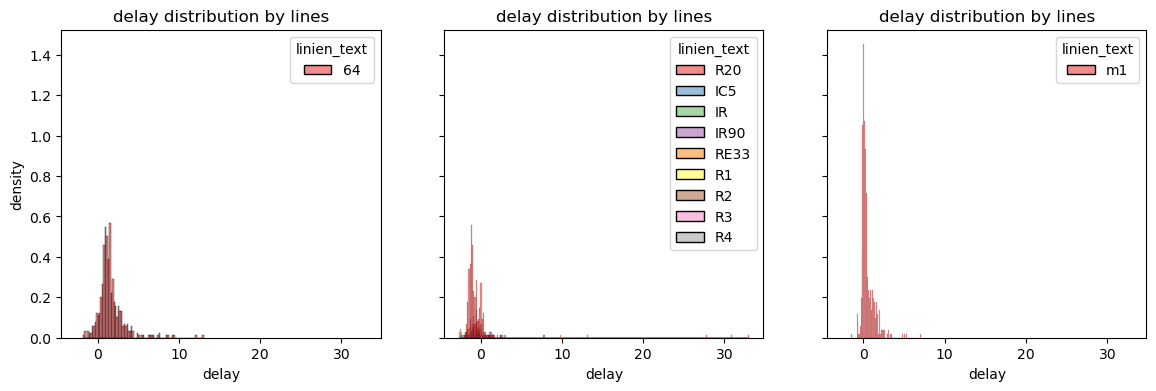

In [28]:
%%local
# influence of the line -> hard to say because not all the lines are in the local dataframe
def plot_hist(data, ax):
    lines = data.linien_text.unique()
    sns.histplot(
        data=data,
        x="delay",
        hue="linien_text",
        stat="density",
        # cumulative=True,
        alpha=0.5,
        palette="Set1",
        ax=ax
    )
    ax.set_ylabel("density")
    ax.set_title("delay distribution by lines")

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

plot_hist(df_bus, ax[0])
plot_hist(df_train, ax[1])
plot_hist(df_metro, ax[2])

plt.show()

### Visualization of delay by weather

In [30]:
%%spark -o df_bad_weather

Interrupted by user


In [ ]:
%%spark -o df_good_weather

In [ ]:
%%local 

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

dfs = [df_bad_weather, df_good_weather]
labels = ['Bad weather', 'Good weather']

for i, (df, label) in enumerate(zip(dfs, labels)):

    data = df.loc[:, 'delay']
    data = data[data >= 0]
    ax[i].hist(data, bins=50, density=True, alpha=0.6, label=f'{label} histogram')
    
    # Fit Gamma distribution
    fit_alpha, fit_loc, fit_beta = stats.gamma.fit(data)
    
    xmin, xmax = ax[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    y = stats.gamma.pdf(x, fit_alpha, loc=fit_loc, scale=fit_beta)
    
    
    ax[i].plot(x, y, 'r-', lw=2, label=f'Fitted gamma {label}')
    ax[i].set_title(f"Distribution of delays (hour) - {label}")
    ax[i].set_xlabel("Delay (min)")
    ax[i].set_ylabel("Density of probability")
    ax[i].legend(loc="best")

plt.tight_layout()
plt.show()


In [ ]:
%%spark -o df_bus_with_weather
df_bus_with_weather = df_with_weather.filter(F.col("produkt_id") == "Bus")

In [ ]:
%%spark -o df_train_with_weather
df_train_with_weather = df_with_weather.filter(F.col("produkt_id") == "Zug")

In [ ]:
%%spark -o df_metro_with_weather
df_metro_with_weather = df_with_weather.filter(F.col("produkt_id") == "Metro")

In [ ]:
%%local

# There are 6 cases
means_transport = ['Bus', 'Train', 'Metro']
weather = ['Bad', 'Good']
# rush_hour = ['false', 'true']

dfs = [df_bus_with_weather, df_train_with_weather, df_metro_with_weather]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30,20))

# Gamma parameters 
gamma_params_dict = {}

# Plot each of the groups
axe_x = 0
axe_y = 0
for mt in range(len(means_transport)):
    for wt in weather:

            # Name of the group
            name = means_transport[mt] + ", " + wt + " weather" 
            delays = dfs[mt][(dfs[mt]["weather_evaluation"] == wt)]["delay"]

            if not delays.empty:
                delays = delays[(delays >= 0)]
        
                # Fit a Gamma distribution
                fit_alpha, fit_loc, fit_scale = stats.gamma.fit(delays)
                gamma_params_dict[name] = {'fit_alpha':fit_alpha, 'fit_loc':fit_loc, 'fit_scale':fit_scale}
            
                # histogram
                axes[axe_y][axe_x].hist(delays, color='#ff66b2', bins=200, density = True, stacked = True)
                ylimits = axes[axe_y][axe_x].get_ylim() 
            
                # Plot the gamma distribution
                x = np.linspace(delays.min(), delays.max(), 200)            
                axes[axe_y][axe_x].plot(x, stats.gamma.pdf(x, fit_alpha, loc=fit_loc, scale=fit_scale),
                                    label = rf'$\alpha$={fit_alpha:.2f}, loc={fit_loc:.2f}, scale={fit_scale:.2f}', 
                                    color='#76d7c4', linewidth=5)
            
            
                axes[axe_y][axe_x].legend()
                axes[axe_y][axe_x].set_ylim(ylimits)
                axes[axe_y][axe_x].grid(True)
                axes[axe_y][axe_x].tick_params(axis='both', which='major', labelsize=10)
                axes[axe_y][axe_x].set_xlabel(name, fontsize=12, labelpad=5)

                # Increment the plot index
                axe_x += 1
                if (axe_x % 2 ==0):
                    axe_x = 0
                    axe_y += 1


# Legends
fig.suptitle('Distribution of delays by type of transport and weather conditions', fontsize=40, y=0.95)
fig.text(0.5, 0.07, 'Delays (in minutes)', ha='center', fontsize=25)
fig.text(0.08, 0.4, 'Probability Density', ha='center', fontsize=25, rotation='vertical')

plt.show()


# Delay modeling

We test two models and compare them. We select the most accurate.<br>
Our metrics are accuracy and . We'd prefer a false positive prediction of delay rather than false negative (i.e we prefer another route if false positive than waiting because we missed the connection because of a false negative).

In [12]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- fahrt_bezeichner: string (nullable = true)
 |-- linien_text: string (nullable = true)
 |-- parent_station: string (nullable = true)
 |-- produkt_id: string (nullable = true)
 |-- bpuic: string (nullable = true)
 |-- stop_id: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_cat: string (nullable = true)
 |-- ankunftszeit: string (nullable = true)
 |-- an_prognose: string (nullable = true)
 |-- abfahrtszeit: string (nullable = true)
 |-- ab_prognose: string (nullable = true)
 |-- ankunftszeit_sec: long (nullable = true)
 |-- an_prognose_sec: long (nullable = true)
 |-- abfahrtszeit_sec: long (nullable = true)
 |-- ab_prognose_sec: long (nullable = true)
 |-- stop_lat: double (nullable = true)
 |-- stop_lon: double (nullable = true)
 |-- stop_name: string (nullable = true)
 |-- delay_bool: boolean (nullable = true)
 |-- delay: double (nullable = true)

### Formatting of data

In [14]:
# transform to correct format: string -> numerical
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Assuming 'df' is your DataFrame with string columns
string_columns = ['produkt_id', 'day_cat']

# Apply StringIndexer to each string column
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in string_columns]

# Chain indexers together into a single Pipeline
pipeline = Pipeline(stages=indexers)

# Fit the pipeline to the DataFrame
data = data_train_stats_delay
data_transformed = pipeline.fit(data).transform(data)

# Drop the original string columns
data_transformed = data_transformed.drop(*string_columns)
data_transformed = data_transformed.select(['rush_hour', 'day_cat_index',
                                            'produkt_id_index',
                                            'stop_lat', 'stop_lon',
                                            'delay_bool'])
data_transformed = data_transformed.withColumn("rush_hour", F.when(data_transformed["rush_hour"] == True, 1).otherwise(0))
data_transformed = data_transformed.withColumn("delay_bool", F.when(data_transformed["delay_bool"] == True, 1).otherwise(0))
print(data_transformed.show(n=5))
print(data_transformed.printSchema())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------------+----------------+---------------+--------------+----------+
|rush_hour|day_cat_index|produkt_id_index|       stop_lat|      stop_lon|delay_bool|
+---------+-------------+----------------+---------------+--------------+----------+
|        0|          0.0|             0.0|46.564852973784|6.693508879657|         0|
|        0|          0.0|             0.0|46.564852973784|6.693508879657|         0|
|        0|          0.0|             0.0|46.564852973784|6.693508879657|         0|
|        0|          0.0|             0.0|46.564852973784|6.693508879657|         0|
|        0|          0.0|             0.0|46.564852973784|6.693508879657|         0|
+---------+-------------+----------------+---------------+--------------+----------+
only showing top 5 rows

None
root
 |-- rush_hour: integer (nullable = false)
 |-- day_cat_index: double (nullable = false)
 |-- produkt_id_index: double (nullable = false)
 |-- stop_lat: double (nullable = true)
 |-- stop_lon: double 

In [31]:
# correspondance indexing and transport type
temp1 = data_transformed.select("produkt_id_index").groupBy("produkt_id_index").agg(F.count("*").alias("frequency"))
temp2 = data_train_stats_delay.select("produkt_id").groupBy("produkt_id").agg(F.count("*").alias("frequency"))
convention_transport = temp1.join(temp2, on="frequency").select("produkt_id_index", "produkt_id")
convention_transport.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------+
|produkt_id_index|produkt_id|
+----------------+----------+
|             0.0|       Bus|
|             1.0|       Zug|
|             2.0|     Metro|
+----------------+----------+

In [19]:
# Split the data into training and test sets
train_data, test_data = data_transformed.randomSplit([0.7, 0.3], seed=42)

# Define the feature columns
feature_columns = data_transformed.columns[:-1]

# Assemble the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
train_data.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

941199

### Training of Logistic Regression model

In [21]:
# Instantiate the logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="delay_bool")

# Train the logistic regression model
lr_model = lr.fit(train_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Training of Random Forest model

In [30]:
# rf = RandomForestClassifier(featuresCol="features", labelCol="delay_bool", numTrees=20)

# # Train the Random Forest model
# rf_model = rf.fit(train_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Testing model

In [22]:
def get_auc(model, predictions):
    evaluator = BinaryClassificationEvaluator(labelCol="delay_bool", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    roc_auc = evaluator.evaluate(predictions)
    return roc_auc

def get_precision(model, predictions):
    precision_evaluator = MulticlassClassificationEvaluator(labelCol="delay_bool", predictionCol="prediction", metricName="weightedPrecision")
    precision = precision_evaluator.evaluate(predictions)
    return precision

def get_recall(model, predictions):
    recall_evaluator = MulticlassClassificationEvaluator(labelCol="delay_bool", predictionCol="prediction", metricName="weightedRecall")
    recall = recall_evaluator.evaluate(predictions)
    return recall

def get_f1_score(model, predictions):
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="delay_bool", predictionCol="prediction", metricName="f1")
    f1_score = f1_evaluator.evaluate(predictions)
    return f1_score

def get_metrics(model, predictions):
    # AUC
    roc_auc = get_auc(model, predictions)
    print("Area under ROC curve: {:.3f}".format(roc_auc))
    
    # Precision
    precision = get_precision(model, predictions)
    print("Precision: {:.3f}".format(precision))
    
    # Recall
    recall = get_recall(model, predictions)
    print("Recall: {:.3f}".format(recall))
    
    # F1 score
    f1_score = get_f1_score(model, predictions)
    print("F1 Score: {:.3f}".format(f1_score))

    return(roc_auc, precision, recall, f1_score)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
predictions_lr = lr_model.transform(test_data)
log_reg_metrics = get_metrics(lr_model, predictions_lr)

# predictions_rf = rf_model.transform(test_data)
# rand_forest_metrics = get_metrics(rf_model, predictions_rf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Area under ROC curve: 0.627
Precision: 0.951
Recall: 0.975
F1 Score: 0.963

# Model validation
To validate the model, we make predictions on the month of March.

# Export coefficients

In [24]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
def extract_coefficients(model):
    # extract coeff
    coefficients = model.coefficients.toArray()
    intercept = model.intercept
    coefficients = np.hstack([intercept, coefficients])
    return coefficients

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# get coefficients in numpy array form
coefs_lr = extract_coefficients(lr_model)
coefs_lr

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([-60.42097449,   1.01804404,   0.        ,  -0.14124128,
         0.55843595,   4.56289174])

In [27]:
# create dataframe with coefficients
data_coef_lr = [(i, float(coef)) for i, coef in enumerate(coefs_lr)]
schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("value", FloatType(), True)
])
coefs_lr_df = spark.createDataFrame(data_coef_lr, schema)
coefs_lr_df.show(n=5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----------+
|index|      value|
+-----+-----------+
|    0| -60.420975|
|    1|   1.018044|
|    2|        0.0|
|    3|-0.14124128|
|    4|  0.5584359|
+-----+-----------+
only showing top 5 rows

In [37]:
coefs_lr_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- index: integer (nullable = true)
 |-- value: float (nullable = true)

In [ ]:
%%sh
hdfs dfs -ls /user/leclercq/livy/
hdfs dfs -chmod 770 /user/leclercq/livy

In [28]:
# save coefficients
model = "lr"
hdfs_path = f"/user/{username}/livy/coefficients_{model}"
coefs_lr_df.write.mode("overwrite").orc(hdfs_path)

spark.sql(f"DROP TABLE IF EXISTS {username}.coefficients_{model}")

spark.sql(f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {username}.coefficients_{model}
(
    index INT,
    value FLOAT
)
STORED AS ORC
LOCATION '{hdfs_path}'
""")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[]

In [37]:
# save conventions
hdfs_path = f"/user/{username}/livy/convention_transport"
convention_transport.write.mode("overwrite").orc(hdfs_path)

spark.sql(f"DROP TABLE IF EXISTS {username}.convention_transport")

spark.sql(f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {username}.convention_transport
(
    produkt_id_index FLOAT,
    produkt_id STRING
)
STORED AS ORC
LOCATION '{hdfs_path}'
""")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[]

In [39]:
hdfs_path = f"/user/{username}/livy/convention_hours"
convention_hours.write.mode("overwrite").orc(hdfs_path)

spark.sql(f"DROP TABLE IF EXISTS {username}.convention_hours")

spark.sql(f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {username}.convention_hours
(
    produkt_id STRING,
    hour INT,
    rush_hour BOOLEAN
)
STORED AS ORC
LOCATION '{hdfs_path}'
""")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[]

In [40]:
print(spark.sql(f"SELECT * FROM {username}.coefficients_lr").show())
print(spark.sql(f"SELECT * FROM {username}.convention_hours").show())
print(spark.sql(f"SELECT * FROM {username}.convention_transport").show())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----------+
|index|      value|
+-----+-----------+
|    0| -60.420975|
|    1|   1.018044|
|    3|-0.14124128|
|    4|  0.5584359|
|    5|   4.562892|
|    2|        0.0|
+-----+-----------+

None
+----------+----+---------+
|produkt_id|hour|rush_hour|
+----------+----+---------+
|       Bus|   6|    false|
|       Bus|   7|     true|
|       Bus|   8|     true|
|       Bus|   9|     true|
|       Bus|  10|    false|
|       Bus|  11|    false|
|       Bus|  12|    false|
|       Bus|  13|    false|
|       Bus|  14|    false|
|       Bus|  15|    false|
|       Bus|  16|     true|
|       Bus|  17|     true|
|       Bus|  18|     true|
|       Bus|  19|    false|
|       Bus|  20|    false|
|       Bus|  21|    false|
|       Bus|  22|    false|
|     Metro|   9|    false|
|     Metro|  12|    false|
|     Metro|  14|     true|
+----------+----+---------+
only showing top 20 rows

None
+----------------+----------+
|produkt_id_index|produkt_id|
+----------------+----------+
|